In [1]:
import glob
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from natsort import natsorted
from msc_filtering import MyKalmanFilter

## Read dataset

In [2]:
all_files = natsorted(glob.glob(os.path.join('./trackkick_results/',"*.res")))
kick_list = []
for file in all_files: 
    df=pd.read_csv(file , sep= ",", header='infer')
    df["kick"] = int(file[30:-4])
    df.columns=df.columns.str.strip()
    kick_list.append(df)

In [3]:
all_files[:5]

['./trackkick_results\\trackkick_1.res',
 './trackkick_results\\trackkick_2.res',
 './trackkick_results\\trackkick_3.res',
 './trackkick_results\\trackkick_4.res',
 './trackkick_results\\trackkick_5.res']

#### Inspect data

In [4]:
kick_list[3]

,time,GT_distance,GT_height,See_distance,See_height,Gyro_rates,kick
0,0.02,0.000,0.0,0.010497,-0.005173,27.11,4
1,0.04,0.000,0.0,0.002875,-0.006686,31.82,4
2,0.06,0.000,0.0,0.007317,0.003766,33.57,4
3,0.08,0.000,0.0,0.009044,0.000136,5.51,4
4,0.10,0.000,0.0,0.014313,-0.000237,7.00,4
...,...,...,...,...,...,...,...
290,5.82,5.486,0.0,5.485230,0.000564,-24.96,4
291,5.84,5.486,0.0,5.493100,-0.001385,13.35,4
292,5.86,5.486,0.0,5.492830,-0.005239,-22.53,4
293,5.88,5.486,0.0,5.493040,-0.003317,-1.21,4


## Investigate a selected kick

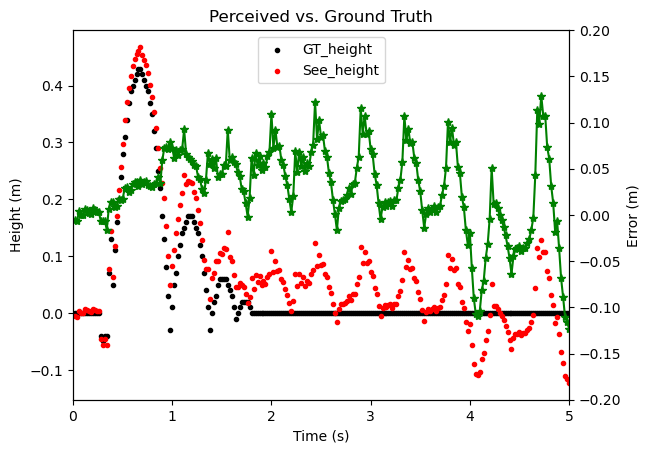

In [5]:
df_data = kick_list[3]
plt.scatter(df_data['time'], df_data['GT_height'] ,marker=".",color="black")
plt.scatter(df_data['time'], df_data['See_height'] ,marker=".",color="red")
plt.title("Perceived vs. Ground Truth")
plt.xlabel("Time (s)")
plt.ylabel("Height (m)")
plt.xlim([0,5])
plt.legend(["GT_height","See_height"],loc='upper center')
plt.twinx()
plt.plot(df_data['time'], df_data['See_height']-df_data['GT_height'] ,marker="*",color="g")
plt.ylabel("Error (m)")
plt.ylim([-0.2,0.2])
plt.show()

Worse error as ball moves further away. Since the noise of the server perceptors is removed, no error is expected. The cyclic nature may be related to the walking in place of the robot so possibly the transform is missing the uprightedness orientation changes of the robot (Check l2g function)

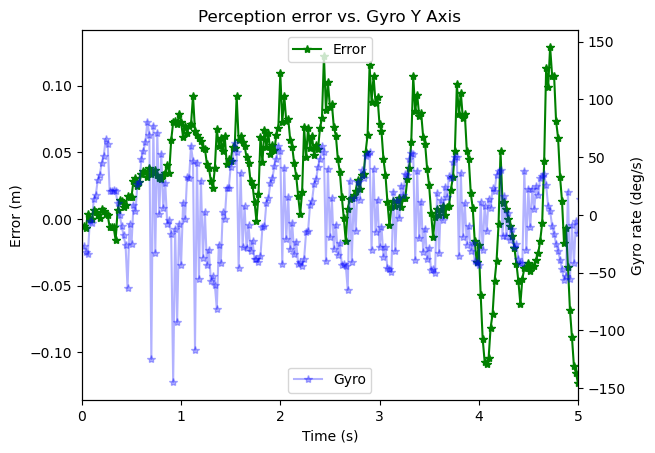

In [6]:
df_data = kick_list[3]
plt.plot(df_data['time'], df_data['See_height']-df_data['GT_height'] ,marker="*",color="g")
plt.title("Perception error vs. Gyro Y Axis")
plt.xlabel("Time (s)")
plt.xlim([0,5])
plt.ylabel("Error (m)")
plt.legend(["Error"],loc='upper center')
plt.twinx()
plt.plot(df_data['time'], -df_data['Gyro_rates'],marker="*",color="b", alpha=0.3)
plt.ylim([-160,160])
plt.ylabel("Gyro rate (deg/s)")
plt.legend(["Gyro"],loc='lower center')
plt.show()

There is a high correleation between the angular acceleration of the Y axis gyro and the error. They appear to have the same frequency. The transform does not seem to account for lack of uprightness

## Plot all kicks

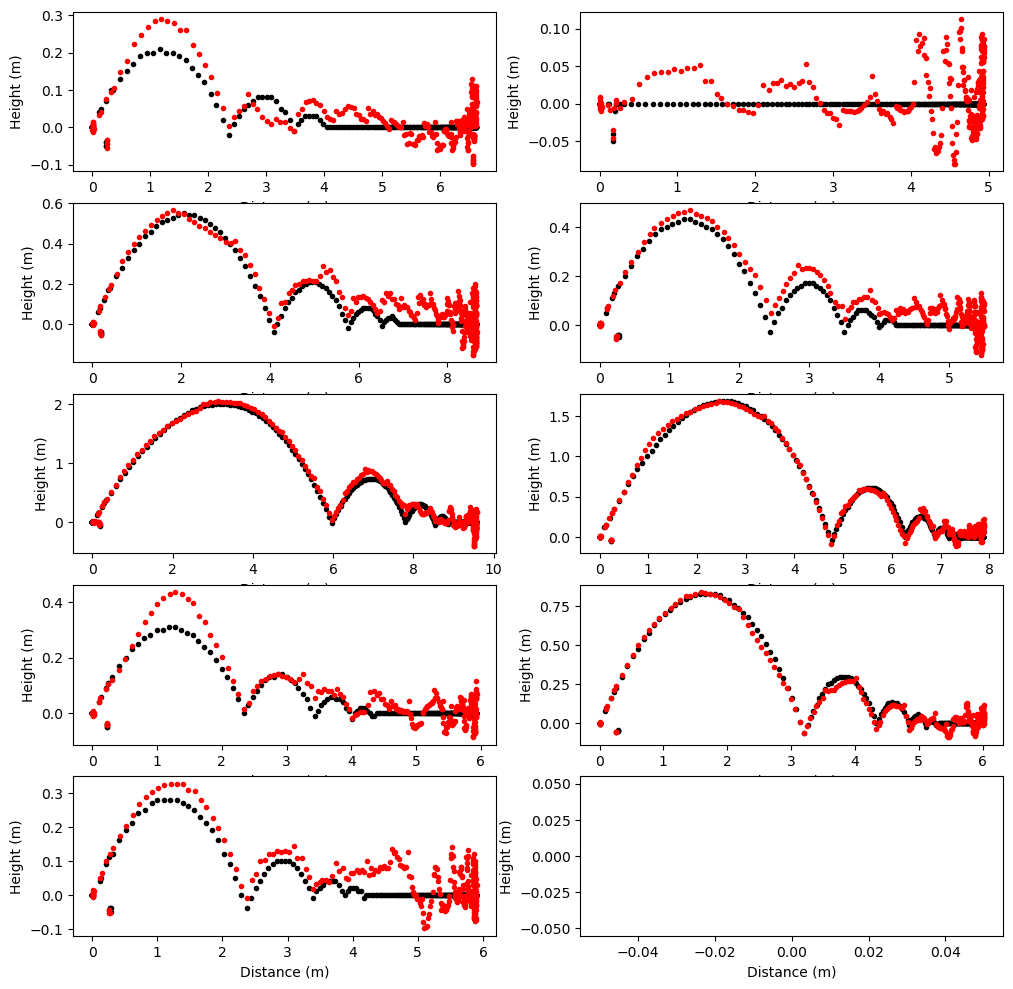

In [7]:
fig,axes = plt.subplots(nrows=5, ncols=2, figsize=(12,12))#, sharex=True, sharey=True)

axes_list=axes.ravel()

for i, ax in enumerate(axes_list):
    df_data = kick_list[i]
    ax.scatter(df_data['GT_distance'], df_data['GT_height'] ,marker=".",color="black")
    ax.scatter(df_data['See_distance'], df_data['See_height'] ,marker=".",color="red")
    ax.set_xlabel("Distance (m)")
    ax.set_ylabel("Height (m)")

plt.show()

Some non-physical measurement feedback is received since its clear that the ground truth shows it as being below the ground and at an offset position... This does may impact the accuracy of our kicking because the server repeats the kick command for multiple time steps

## Test Kalman filtering

####  Linear with constant model

Water tank with constant level at L=1

In [8]:
x0 = 0  # Initial value - arbitrary guess
p0 = 1000  # State covariances (Error of estimation) - High since unknown
q = 0.0001  # System noise
r = 0.1  # Measurement noise

In [9]:
def constant_func(input):
    return input

Instantiate filter

In [10]:
testFilter = MyKalmanFilter(x0, p0, constant_func, r, q)

Initialise model


Evaluate against synthetic data

In [11]:
%%capture
xt_intr_list = []
Pt_intr_list = []
k_gain_list = []
xt_curr_list = []
Pt_curr_list = []

measure_list = [0.9, 0.8, 1.1, 1, 0.95, 1.05, 1.2, 0.9, 0.85, 1.15]
for measure in measure_list:
    testFilter.step(measure);
    xt_intr_list.append(testFilter.xt_intr)
    Pt_intr_list.append(testFilter.Pt_intr)
    k_gain_list.append(testFilter.k_gain)
    xt_curr_list.append(testFilter.xt_curr)
    Pt_curr_list.append(testFilter.Pt_curr)

Check results

In [14]:
list_of_lists = [xt_intr_list,Pt_intr_list,k_gain_list,xt_curr_list,Pt_curr_list]
df_level = pd.DataFrame(list(zip(*list_of_lists)), columns= ['xt_intr','Pt_intr','k_gain','xt_curr','Pt_curr'])

In [15]:
df_level

,xt_intr,Pt_intr,k_gain,xt_curr,Pt_curr
0,0.000000,1000.000100,0.999900,0.899910,0.099990
1,0.899910,0.100090,0.500225,0.849933,0.050022
2,0.849933,0.050122,0.333877,0.933424,0.033388
3,0.933424,0.033488,0.250867,0.950126,0.025087
4,0.950126,0.025187,0.201193,0.950101,0.020119
5,0.950101,0.020219,0.168187,0.966902,0.016819
6,0.966902,0.016919,0.144705,1.000633,0.014470
7,1.000633,0.014570,0.127175,0.987835,0.012717
8,0.987835,0.012817,0.113613,0.972175,0.011361
9,0.972175,0.011461,0.102827,0.990460,0.010283


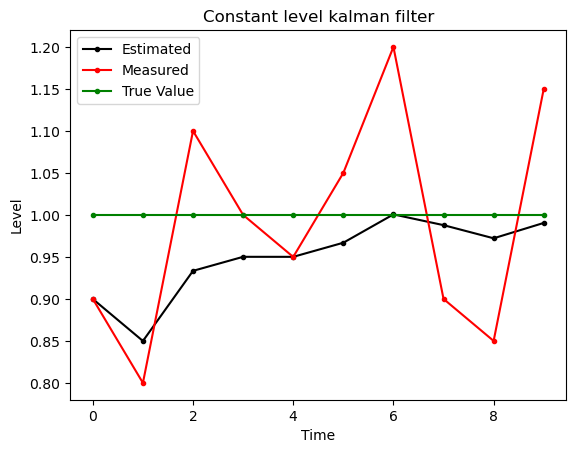

In [27]:
plt.plot(df_level.index, df_level['xt_curr'] ,marker=".",color="black")
plt.plot(df_level.index, measure_list ,marker=".",color="red")
plt.plot(df_level.index, np.ones(len(df_level.index)) ,marker=".",color="g")
plt.title("Constant level kalman filter")
plt.xlabel("Time")
plt.ylabel("Level")
plt.legend(["Estimated","Measured","True Value"],loc='upper left')
plt.show()